In [28]:
from collections import Counter
import json
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import pgeocode
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances
from uszipcode import SearchEngine

In [29]:
pd.set_option('display.max_rows', None)
plt.rcParams.update({'font.size': 22})

In [30]:
with open('zipcode_to_city_denver.txt', 'r') as f:
    zipcode_to_city_denver = json.loads(f.read())
    
denver_zipcodes = sorted(list(zipcode_to_city_denver))
zipcode_to_city_denver = {zipcode: zipcode_to_city_denver[zipcode] for zipcode in denver_zipcodes}

In [31]:
# calculate distance from each ZIP code to the center of Denver
denver_center = np.array([radians(39.739681), radians(-104.988904)]).reshape(1,-1)

us_geocoder = pgeocode.Nominatim('us')
geo_info = us_geocoder.query_postal_code(pd.Series(denver_zipcodes).astype(str))
geo_info = geo_info[['postal_code', 'latitude', 'longitude']]
geo_info['lat_rad'] = geo_info['latitude'].apply(radians)
geo_info['lon_rad'] = geo_info['longitude'].apply(radians)
# Distances in km
distance_matrix = haversine_distances(geo_info[['lat_rad', 'lon_rad']], denver_center) * (6371000 / 1000)

In [32]:
# dataframe to store all ZIP code-level features
zipcode_feature_df = pd.DataFrame(distance_matrix.flatten(), columns=['distance_to_center_city'], 
                                  index=denver_zipcodes)

In [33]:
zipcode_feature_df['city'] = [x.rstrip() for x in zipcode_to_city_denver.values()]

In [34]:
search = SearchEngine(simple_zipcode=True)
zipcode_population = [search.by_zipcode(zipcode).population for zipcode in denver_zipcodes]
zipcode_feature_df['population'] = zipcode_population

In [35]:
# indicators of whether ZIP code is in Denver proper or is in the neighboring cities of Aurora or Lakewood
# which are considered to be part of the urban core of the Denver metropolitan area
is_in_denver = [int(zipcode_to_city_denver[zipcode] == 'Denver') for zipcode in denver_zipcodes]
is_in_neighboring_cities = [int(zipcode_to_city_denver[zipcode] in {'Aurora', 'Lakewood'})
                            for zipcode in denver_zipcodes]

zipcode_feature_df['in_denver'] = is_in_denver
zipcode_feature_df['in_neighboring_cities'] = is_in_neighboring_cities

In [36]:
# only consider price reductions that were greater than $1000
min_price_reduction = -1000
denver_price_change_df = pd.read_csv('denver_price_change.csv')
denver_price_change_df['zipcode'] = denver_price_change_df['zipcode'].astype(str)
denver_price_change_df = denver_price_change_df[denver_price_change_df.price_change <= min_price_reduction]

In [37]:
# don't double count listing that had multiple price reduction 
print(denver_price_change_df.shape)
denver_price_change_df.drop_duplicates(subset='property_id', keep='first', 
                                       inplace=True)
print(denver_price_change_df.shape)

(254076, 4)
(94470, 4)


In [38]:
zipcode_to_price_reduction_cnt = dict(Counter(denver_price_change_df.zipcode))

In [39]:
denver_listing_dates_df = pd.read_csv('denver_listing_dates.csv')
denver_listing_dates_df['zipcode'] = denver_listing_dates_df['zipcode'].astype(str)

In [40]:
denver_listing_dates_df.shape

(451235, 11)

In [41]:
denver_listing_dates_df_no_dups = denver_listing_dates_df.drop_duplicates(subset='property_id', keep='first')

In [42]:
zipcode_to_listing_cnt = dict(Counter(denver_listing_dates_df_no_dups.zipcode))

In [43]:
# divide number of listings with price reduction by the total number of listings in ZIP code
price_reduction_fractions = [(zipcode_to_price_reduction_cnt.get(zipcode, np.nan) / 
                              zipcode_to_listing_cnt.get(zipcode, np.nan))
                             for zipcode in denver_zipcodes]

In [44]:
zipcode_feature_df['price_red_frac'] = price_reduction_fractions

In [45]:
denver_listing_dates_df_sold = denver_listing_dates_df[denver_listing_dates_df.sale_price.notna()]

In [46]:
# calculate median sale price by ZIP code
median_sale_price_df = denver_listing_dates_df_sold.groupby('zipcode').agg({'sale_price': np.median})
median_sale_price_df.rename(columns={'sale_price': 'median_sale_price'}, inplace=True)

In [47]:
zipcode_feature_df = zipcode_feature_df.merge(median_sale_price_df, how='left', left_index=True, right_index=True)

In [48]:
colorado_population_estimates_df = pd.read_csv('colorado_population_estimates.csv', header=3)
colorado_population_estimates_df.rename(columns={'Unnamed: 0': 'city'}, inplace=True)

In [49]:
colorado_population_estimates_df.head()

,city,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Aguilar town, Colorado",538,537,534,517,512,485,468,468,469,473,482,480
1,"Akron town, Colorado","1,702","1,702","1,705","1,684","1,665","1,677","1,672","1,690","1,705","1,730","1,718","1,723"
2,"Alamosa city, Colorado","8,780","8,876","8,917","9,030","9,035","9,109","9,156","9,270","9,361","9,455","9,566","9,591"
3,"Alma town, Colorado",270,274,275,272,272,275,280,285,296,304,312,313
4,"Antonito town, Colorado",781,781,786,784,777,770,770,751,745,749,750,747


In [50]:
# calculate linear growth trend in each ZIP code 
avg_growth_rate_lst = []
lin_reg = LinearRegression()
cnt = 0
for _, row in colorado_population_estimates_df.iterrows():
    try:
        city = row['city']
        city = ' '.join(city.replace(',', '').split()[:-2])
        pop_estimates = np.array([int(x.replace(',', '')) for x in row[3:]])
        lin_reg.fit(np.arange(len(pop_estimates)).reshape(-1, 1), pop_estimates)
        slope = lin_reg.coef_[0]
        avg_growth_rate_lst.append((city, slope / pop_estimates[0]))
    except (ValueError, AttributeError) as e:
        pass

In [51]:
avg_growth_rate_df = pd.DataFrame(avg_growth_rate_lst, columns=['city', 'avg_growth_rate'])
zipcode_feature_df = (zipcode_feature_df.reset_index()
                      .merge(avg_growth_rate_df, how='left', on='city').set_index('index'))

In [55]:
# some ZIP codes are in locations that don't have population estimates 
zipcode_feature_df[zipcode_feature_df.avg_growth_rate.isna()]

,distance_to_center_city,city,population,in_denver,in_neighboring_cities,price_red_frac,median_sale_price,avg_growth_rate
index,,,,,,,,
80024,13.104293,Dupont,228.0,0,0,0.090909,250000.0,NaN
80025,33.337853,Eldorado Springs,253.0,0,0,0.368421,599000.0,NaN
80103,67.467536,Byers,2458.0,0,0,0.247159,370000.0,NaN
80116,46.624126,Franktown,3942.0,0,0,0.266017,655000.0,NaN
80131,29.318824,Louviers,243.0,0,0,0.260870,410000.0,NaN
80135,48.109626,Sedalia,3833.0,0,0,0.238519,527000.0,NaN
80137,34.757658,Watkins,1323.0,0,0,0.139241,500000.0,NaN
80425,46.069561,Buffalo Creek,184.0,0,0,0.200000,318750.0,NaN
80433,37.247250,Conifer,8354.0,0,0,0.232947,485000.0,NaN


In [ ]:
plt.figure(figsize=(20, 10))
plt.hist([x for x in zipcode_feature_df.avg_growth_rate if x < 0.5], density=True)
plt.xlabel('average annual population growth rate since 2010')
plt.ylabel('density')
plt.title('population growth in Denver market area by ZIP code')
plt.show()

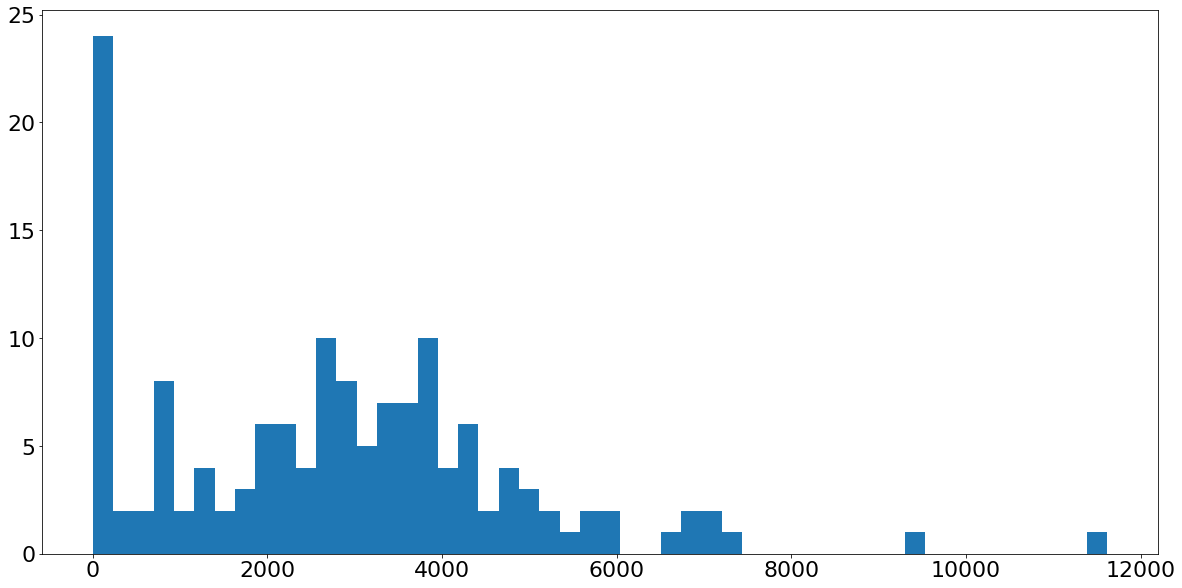

In [56]:
a = denver_listing_dates_df_no_dups.groupby('zipcode').agg({'property_id': len})
plt.figure(figsize=(20, 10))
plt.hist(a['property_id'], bins=50)
plt.show()

In [57]:
len(a['property_id'])

144

In [67]:
sum(a['property_id'] > 3)

129